170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting epoch 1/400
Epoch 1 completed: Gen Loss: 2.8589348793029785, Disc Loss: 0.6565154194831848
Starting epoch 2/400
Epoch 2 completed: Gen Loss: 3.2338716983795166, Disc Loss: 0.3262699544429779
Starting epoch 3/400
Epoch 3 completed: Gen Loss: 2.7967586517333984, Disc Loss: 0.4965050220489502
Starting epoch 4/400
Epoch 4 completed: Gen Loss: 1.8307348489761353, Disc Loss: 0.7852705121040344
Starting epoch 5/400
Epoch 5 completed: Gen Loss: 1.777825117111206, Disc Loss: 0.7818232178688049
Starting epoch 6/400
Epoch 6 completed: Gen Loss: 1.4223997592926025, Disc Loss: 1.0237746238708496
Starting epoch 7/400
Epoch 7 completed: Gen Loss: 1.269656777381897, Disc Loss: 1.056974172592163
Starting epoch 8/400
Epoch 8 completed: Gen Loss: 1.1918140649795532, Disc Loss: 1.1363027095794678
Starting epoch 9/400
Epoch 9 completed: Gen Loss: 1.1517292261123657, Disc Loss: 1.1062262058258057
Starting epoch 10/400
Epoch 10 completed: Gen Loss: 1.0845741033554077, Disc Loss: 1.1353392601013184
S

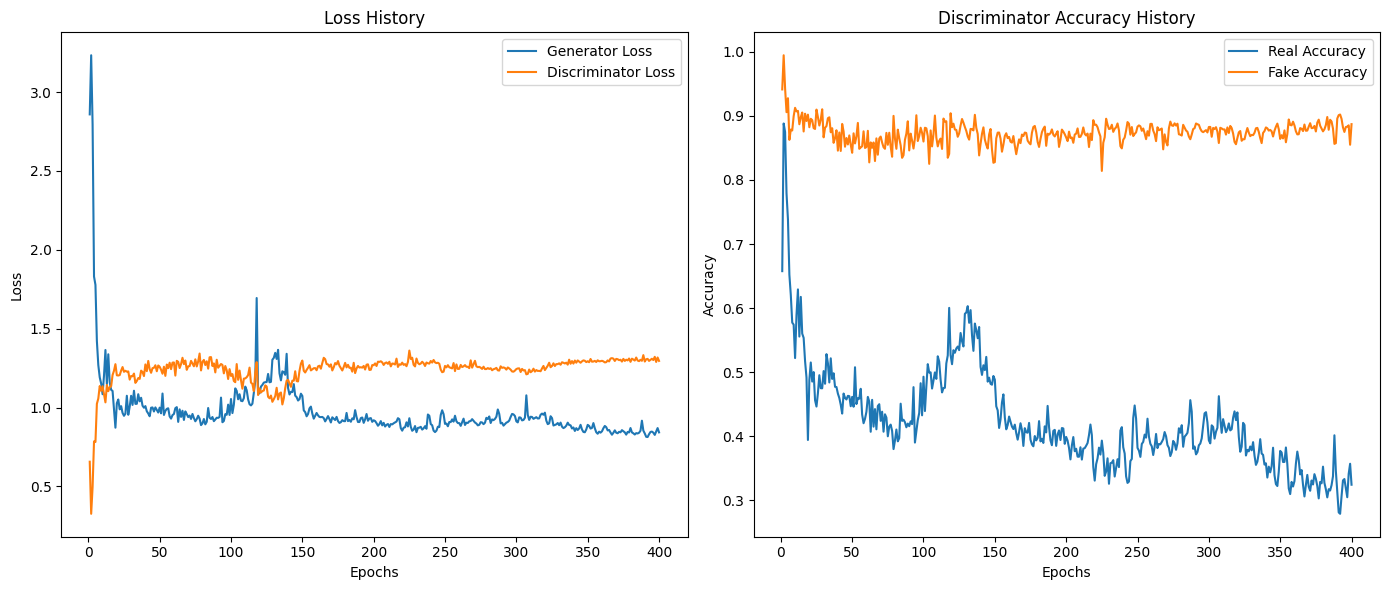

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# 데이터 로드 및 전처리
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32') / 127.5 - 1.0  # [-1, 1]로 정규화
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)

BUFFER_SIZE = 50000
BATCH_SIZE = 128
noise_dim = 100  # 랜덤 노이즈 벡터 차원
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 seed

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator 정의
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='tanh'))
    return model

# Discriminator 정의
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# 모델 생성
generator = make_generator_model()
discriminator = make_discriminator_model()

# 손실 함수 및 옵티마이저 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 체크포인트 설정
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 훈련 함수
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, real_output, fake_output

# 이미지 생성 및 저장
def generate_and_save_images(model, epoch, test_input, save_dir='generated_images'):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2  # [-1, 1] → [0, 1]
    os.makedirs(save_dir, exist_ok=True)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')
    plt.savefig(f'{save_dir}/image_at_epoch_{epoch:04d}.png')
    plt.close(fig)

# 훈련 히스토리 시각화
def draw_train_history(history):
    epochs = range(1, len(history['gen_loss']) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['gen_loss'], label='Generator Loss')
    plt.plot(epochs, history['disc_loss'], label='Discriminator Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['real_accuracy'], label='Real Accuracy')
    plt.plot(epochs, history['fake_accuracy'], label='Fake Accuracy')
    plt.title('Discriminator Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 학습 루프
def train(dataset, epochs, save_interval=5):
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}
    for epoch in range(epochs):
        print(f'Starting epoch {epoch + 1}/{epochs}')
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        epoch_real_acc = 0
        epoch_fake_acc = 0
        num_batches = 0
        for image_batch in dataset:
            gen_loss, disc_loss, real_output, fake_output = train_step(image_batch)
            real_accuracy = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
            fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            epoch_real_acc += real_accuracy
            epoch_fake_acc += fake_accuracy
            num_batches += 1
        history['gen_loss'].append(epoch_gen_loss / num_batches)
        history['disc_loss'].append(epoch_disc_loss / num_batches)
        history['real_accuracy'].append(epoch_real_acc / num_batches)
        history['fake_accuracy'].append(epoch_fake_acc / num_batches)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % save_interval == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print(f'Epoch {epoch + 1} completed: Gen Loss: {history["gen_loss"][-1]}, '
              f'Disc Loss: {history["disc_loss"][-1]}')
    draw_train_history(history)

# 학습 시작
EPOCHS = 400
train(train_dataset, EPOCHS)


In [2]:
import imageio
import os

def create_gif(image_folder, output_gif='dcgan_results.gif', fps=5):
    """
    이미지 파일을 GIF로 생성하는 함수
    :param image_folder: 이미지가 저장된 폴더 경로
    :param output_gif: 생성될 GIF 파일명
    :param fps: 초당 프레임 수 (프레임 속도)
    """
    images = []
    files = sorted(os.listdir(image_folder))  # 파일 이름을 정렬해 순서대로 연결
    for file_name in files:
        if file_name.endswith('.png'):  # PNG 파일만 선택
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))

    # GIF 생성
    imageio.mimsave(output_gif, images, fps=fps)
    print(f"GIF saved at {output_gif}")


In [3]:
# 학습 중 이미지 저장 폴더
image_folder = './generated_images'

# GIF 생성
create_gif(image_folder, output_gif='dcgan_results.gif', fps=5)


<ipython-input-2-24c2303a0a3e>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF saved at dcgan_results.gif
